# Wstęp

Tematem projektu będzie zaprojektowanie oraz zaimplementowanie algorytmu przystosowanego do wykrywania oraz klasyfikowania obraźliwych komentarzy w Internecie. Dzięki narzędziom Machine Learning oraz Natural Language Processing możliwym jest stworzenie systemu, który będzie w stanie wykrywać obraźliwe i wulgarne wypowiedzi.

W ramach projektu dokonany zostanie przegląd rozwiązań zaproponowanych w pracach magisterskich, doktoranckich oraz w artykułach naukowych. Dodatkowo zgromadzony zostanie korpus oznaczonych internetowych komentarzy przeznaczonych do treningu klasyfikatorów wyspecjalizowanych w wykrywaniu komentarzy obraźliwych.

Na koniec przeprowadzona zostanie seria eksperymentów porównująca metody reprezentacji wektorowej tekstu oraz algorytmów uczenia maszynowego.

Cały etap projektowania modelu podzielony został na etapy, które umożliwią zoptymalizowanie danych pod kątem logicznym, tak, aby możliwe stało się ich jak najlepsze wykorzystanie w celach klasyfikacji. Tymi krokami są:

1. Zaimportowanie danych oraz bibliotek
2. Analiza danych korpusu
3. Analiza cech nieruchomości
4. Imputacja brakujących danych oraz wyczyszczenie danych
5. Optymalizacja danych
6. Budowa modelu i predykcja


# 1. Zaimportowanie danych oraz bibliotek

## 1.1 Zaimportowanie bibliotek


In [1]:
#import required packages
#basics
import pandas as pd
import numpy as np

#misc
import gc
import time
import warnings

#stats
# from scipy.misc import imread
from scipy import sparse
import scipy.stats as ss

#viz
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
# import matplotlib_venn as venn

#nlp
import string
import re    #for regex
import nltk
from nltk.corpus import stopwords
import spacy
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
# Tweet tokenizer does not split at apostophes which is what we want
from nltk.tokenize import TweetTokenizer

#FeatureEngineering
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

#Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

#settings
start_time=time.time()
color = sns.color_palette()
sns.set_style("dark")
eng_stopwords = set(stopwords.words("english"))
warnings.filterwarnings("ignore")

lem = WordNetLemmatizer()
tokenizer=TweetTokenizer()

%matplotlib inline

Using TensorFlow backend.


Na początku zaimportowane zostaną wszystkie biblioteki, dzięki którym znacząco ułatwiony zostanie proces analizowania danych oraz budowy modeli klasyfikatorów. Wśród nich znajdują się biblioteki:

1. Pandas - jest opensource'ową biblioteką, wydawaną na licencji BSD, która dostarcza zaawansowanych mechanizmów tworzenia struktur danych oraz ich analizy w języku Python;
2. NumPy - jest podstawową bilblioteką wykorzystywaną w obliczeniach inżynierskich wykonywanych w Pythonie. Dostarcza mechanizmów tworzenia N-wymiarowych tablic, skomplikowanych funkcji matematycznych oraz integracji z kodami źródłowymi napisanymi w językach C/C++ oraz Fortran. Jednak najważniejszą funkcjonalnością pozostaje możliwość tworzenia kontenerów danych w celach ich późniejszej analizy.
3. Seaborn - jest biblioteką, opartą o pakiet matplotlib, umożliwiającą wizualizacje danych i analiz w Pythonie na zaawansowanym poziomie
4. matplotlib - ta biblioteka dostarcza mechanizmów rysowania gotowych do publikacji wykresów w wielu ogólnodostępnych formatach oraz w wielu środowiskach, w tym w wykorzystywanym w projekcie Jupyter Notebook.
5. SciPy - dostarcza wielu mechanizmów, które umożliwiają na wykonanie często używanych operacji numerycznych, jak integracja, interpolacja, optymalizacja czy statystyka
6. scikit-learn - jedna z najważniejszych bibliotek, która dostarcza mechanizmów sztucznej inteligencji w języku Python. Zawiera implmenetacje alogrytmów klasyfikacji, regresji oraz klasteryzacji opartych na metodach gradientowego wzmacniania regrecji, lasów losowych czy wykorzystywanych w projekcie maszynach wektorów nośnych. Dodatkowo jest kompatybilna i współpracuje razem z bibliotekami SciPy oraz NumPy
7. Keras - jest otwartoźródłową bilblioteką dostarczającą mechanizmów konstrukcji sieci neuronowych, napisaną w języku Python. Jest przystosowana do działania wspólnie z bibliotekami TensorFlow, Microsoft Cognitive Toolkit, R, Theano i PlaidMLDesigned. 
to enable fast experimentation with deep neural networks, it focuses on being user-friendly, modular, and extensible. It was developed as part of the research effort of project ONEIROS (Open-ended Neuro-Electronic Intelligent Robot Operating System),[4] and its primary author and maintainer is François Chollet, a Google engineer. Chollet also is the author of the XCeption deep neural network model.[5]
8. nltk - zestaw bibliotek i programów do symbolicznego i statystycznego przetwarzania języka naturalnego, przygotowanego dla języka angielskiego. NLTK zawiera demonstracje graficzne i przykładowe dane. NLTK zostało zaprojektowane z myślą wspierania nauki NLP i zbliżonych dziedzin, w skład których wchodzą lingwistyka, sztuczna inteligencja, Information Retrieval i uczenie maszynowe.

## 1.2 Zaimportowanie danych

In [2]:
train = pd.read_csv('./train_cropped.csv').fillna(' ')
test = pd.read_csv('./test_cropped.csv').fillna(' ')
# train = pd.read_csv('./train.csv').fillna(' ')
# test = pd.read_csv('./test.csv').fillna(' ')


W dwóch plikach .csv zawarte są dane, które zostaną wykorzystane w celach budowy modeli klasyfikujących. Dane składają się z zebranych komentarzy ze stron Wikipedii i zawartych w niej artykułów z lat 2004-2015, które zostały zgłoszone i oznaczone przez użytkowników jako obraźliwe. Korpus jest ogólnie dostępny  pod licencją Creative Commons 0.


In [3]:
# # Check the numbers of samples and features
# print("The train data size before dropping Id feature is : {} ".format(train.shape))
# print("The test data size before dropping Id feature is : {} ".format(test.shape))

# # Save the 'Id' column
# train_ID = train['id']
# test_ID = test['id']

# # Now drop the 'Id' column since it's unnecessary for the prediction process.
# train.drop("id", axis = 1, inplace = True)
# test.drop("id", axis = 1, inplace = True)

# # Check data size after dropping the 'Id' variable
# print("\nThe train data size after dropping Id feature is : {} ".format(train.shape)) 
# print("The test data size after dropping Id feature is : {} ".format(test.shape))

Można zauwazyć, że dane z pliku train.csv zawierają sześć kolumn więcej niż dane z pliku test.csv. Te kolumny stanowią informacje o przynależności do poszczególnych grup toksyczności, którą model ma za zadanie przewidzieć.

Kolumna, informująca o identyfikatorze poszczególnych rekordów, zostanie na czas analizy i budowania modelu odłączona od danych.

In [4]:
train.tail(5)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
16230,2ac94d5c906df483,"""\nI didn't add """"derpyday"""", I think the IP d...",0,0,0,0,0,0
16231,2ac9c426358cf744,"""\n\nHEY CHRIS, HEY HEY!!! I ADDED SOURCED INF...",0,0,0,0,0,0
16232,2acbe19792b2ba7c,"""\n\n My perspective on the changes that need ...",0,0,0,0,0,0
16233,2acc08cd1a1c89fc,"""\n\nArticle size\nWP:Article size means this ...",0,0,0,0,0,0
16234,2accab40fc310915,"""\nActually, I don't think it's particularly '...",0,0,0,0,0,0


In [5]:
test.tail(5)


,id,comment_text
10499,1192f4b4ef73214d,== TL;DR == \n\n ===== THE ASS WAS FAT =====
10500,11932b5fb30ae0b9,== Suck a weiner == \n\n Don't mess with my fr...
10501,11932f93069976a0,":I'm not a paleontologist, I just stumbled int..."
10502,1193b0340e4ac295,""" \n\n == Pork Pie Jeffery article == \n\n Hi...."
10503,11948d106f2b0d9f,""" \n\n \n Dear GeneralNeo, can you kindly rea..."


In [6]:
class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

Różne platformy i serwisy internetowe mają różne standardy oceny toksyczności komentarzy, dlatego przyjęto, że komentarze obraźliwe zostały podzielone na 6 podkategorii:

1. złośliwy
2. bardzo złośliwy
3. nieprzyzwoity
4. groźba
5. obraza
6. dyskryminujący ze względu na przynależność

Kategoryzowanie komentarzy odbyło się za pomocą metody **crowdsourcingu**, co oznacza, że komentarze oceniane były przez różnych ludzi, przez co ich dokładność może nie być perfekcyjna.

## 1.3 Przykładowe komentarze

In [7]:
print("toxic:")
print(train[train.toxic==1].iloc[4,1])

toxic:
FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!


In [8]:
print("severe_toxic:")
print(train[train.severe_toxic==1].iloc[4,1])

severe_toxic:
What a motherfucking piece of crap those fuckheads for blocking us!


In [9]:
print("Threat:")
print(train[train.threat==1].iloc[4,1])

Threat:
WOULDN'T BE THE FIRST TIME BITCH. FUCK YOU I'LL FIND OUT WHERE YOU LIVE, SODOMIZE YOUR WIFE AND THEN BURN YOUR HOUSE DOWN. FUCK YOU YOU FUCKING QUEER.


In [10]:
print("Obscene:")
print(train[train.obscene==1].iloc[4,1])

Obscene:
Stupid peace of shit stop deleting my stuff asshole go die and fall in a hole go to hell!


In [11]:
print("identity_hate:")
print(train[train.identity_hate==1].iloc[4,1])

identity_hate:
u r a tw@ fuck off u gay boy.U r smelly.Fuck ur mum poopie


# 2. Analiza danych


## 2.1 Zbalansowanie klasy

In [12]:
x=train.iloc[:,2:].sum()
#marking comments without any tags as "clean"
rowsums=train.iloc[:,2:].sum(axis=1)
train['clean']=(rowsums==0)
#count number of clean entries
train['clean'].sum()
print("Total comments = ",len(train))
print("Total clean comments = ",train['clean'].sum())
print("Total tags =",x.sum())

Total comments =  16235
Total clean comments =  14593
Total tags = 3590


opis zbilansowania

## 2.2 Imputacja brakujących danych oraz wyczyszczenie danych


In [13]:
print("Check for missing values in Train dataset")
null_check=train.isnull().sum()
print(null_check)
print("Check for missing values in Test dataset")
null_check=test.isnull().sum()
print(null_check)
print("filling NA with \"unknown\"")
train["comment_text"].fillna("unknown", inplace=True)
test["comment_text"].fillna("unknown", inplace=True)

Check for missing values in Train dataset
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
clean            0
dtype: int64
Check for missing values in Test dataset
id              0
comment_text    0
dtype: int64
filling NA with "unknown"


opis brakujacych wartosci

## 2.3 Rozproszenie komentarzy toksycznych


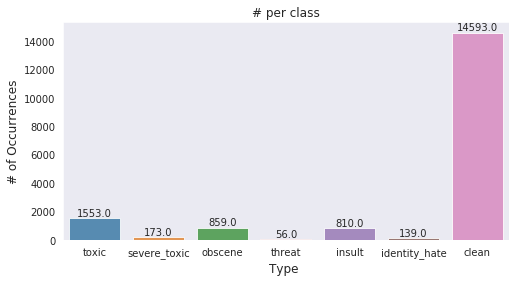

In [14]:
x=train.iloc[:,2:].sum()
#plot
plt.figure(figsize=(8,4))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("# per class")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)
#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

The toxicity is not evenly spread out across classes. Hence we might face class imbalance problems
There are ~95k comments in the training dataset and there are ~21 k tags and ~86k clean comments!?
This is only possible when multiple tags are associated with each comment (eg) a comment can be classified as both toxic and obscene.

## 2.4 Współwystępowanie kategorii toksyczności


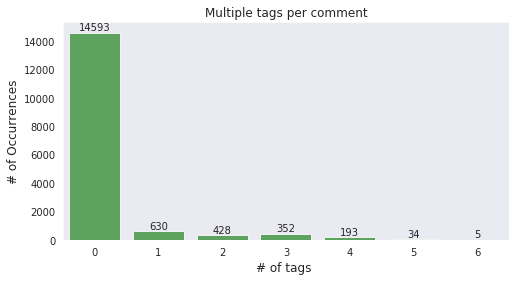

In [15]:
x=rowsums.value_counts()

#plot
plt.figure(figsize=(8,4))
ax = sns.barplot(x.index, x.values, alpha=0.8,color=color[2])
plt.title("Multiple tags per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of tags ', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

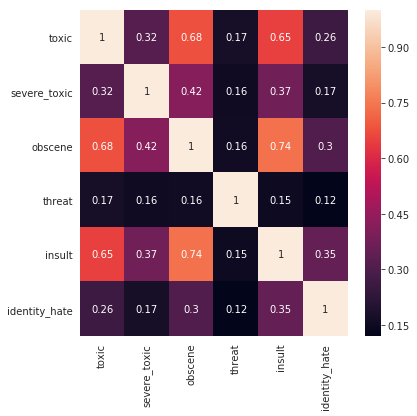

In [16]:
temp_df=train.iloc[:,2:-1]
# filter temp by removing clean comments
# temp_df=temp_df[~train.clean]

corr=temp_df.corr()
plt.figure(figsize=(6,6))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True)

The above plot indicates a pattern of co-occurance but Pandas's default Corr function which uses Pearson correlation does not apply here, since the variables invovled are Categorical (binary) variables.

So, to find a pattern between two categorical variables we can use other tools like

Confusion matrix/Crosstab
Cramer's V Statistic
Cramer's V stat is an extension of the chi-square test where the extent/strength of association is also measured


In [17]:
#Crosstab
# Since technically a crosstab between all 6 classes is impossible to vizualize, lets take a 
# look at toxic with other tags
main_col="toxic"
corr_mats=[]
for other_col in temp_df.columns[1:]:
    confusion_matrix = pd.crosstab(temp_df[main_col], temp_df[other_col])
    corr_mats.append(confusion_matrix)
out = pd.concat(corr_mats,axis=1,keys=temp_df.columns[1:])

#cell highlighting
# out = out.style.apply(highlight_min, axis=0)
out

severe_toxic      obscene      threat     insult       \
severe_toxic            0    1       0    1      0   1      0    1   
toxic                                                                
0                   14682    0   14631   51  14680   2  14626   56   
1                    1380  173     745  808   1499  54    799  754   

             identity_hate       
severe_toxic             0    1  
toxic                            
0                    14672   10  
1                     1424  129

The above table represents the Crosstab/ consufion matix of Toxic comments with the other classes.

Some interesting observations:

A Severe toxic comment is always toxic
Other classes seem to be a subset of toxic barring a few exceptions

## 2.5 Chmury znaczników dla poszczególnych kategorii


Chmury znaczników to graficzne zobrazowanie zawartości korpusu tekstowego w postaci zestawu znaczników. Najczęściej znaczniki są uszeregowane alfabetycznie, natomiast wielkość i pogrubienie fontu poszczególnych znaczników–linków jest zależne od ważności lub popularności danego znacznika. Umożliwia to łatwe znalezienie danej kategorii zarówno alfabetycznie, jak i według ważności.

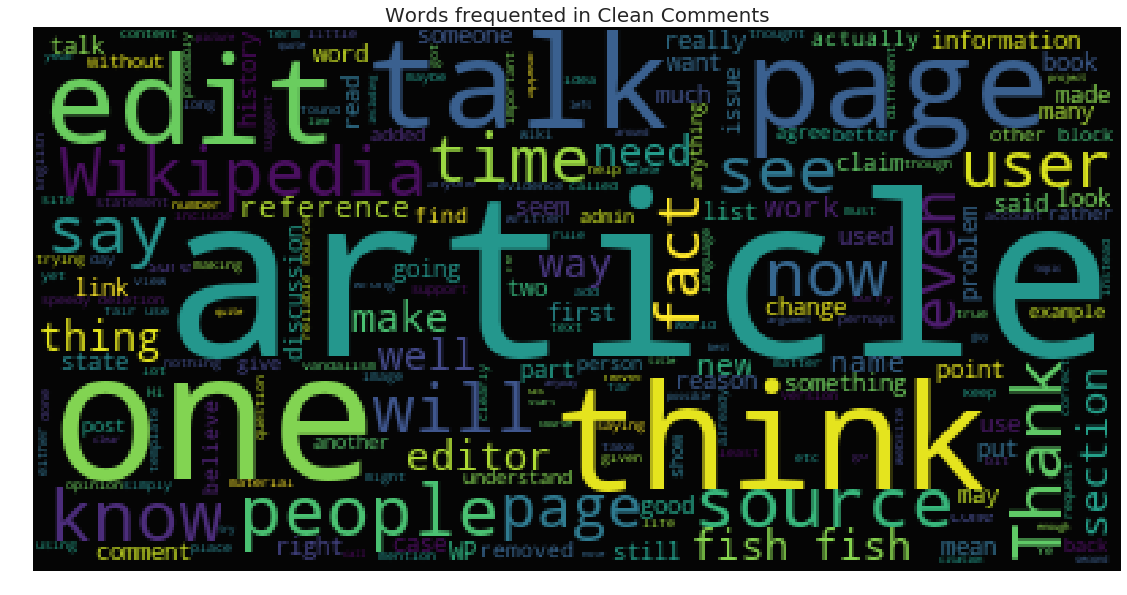

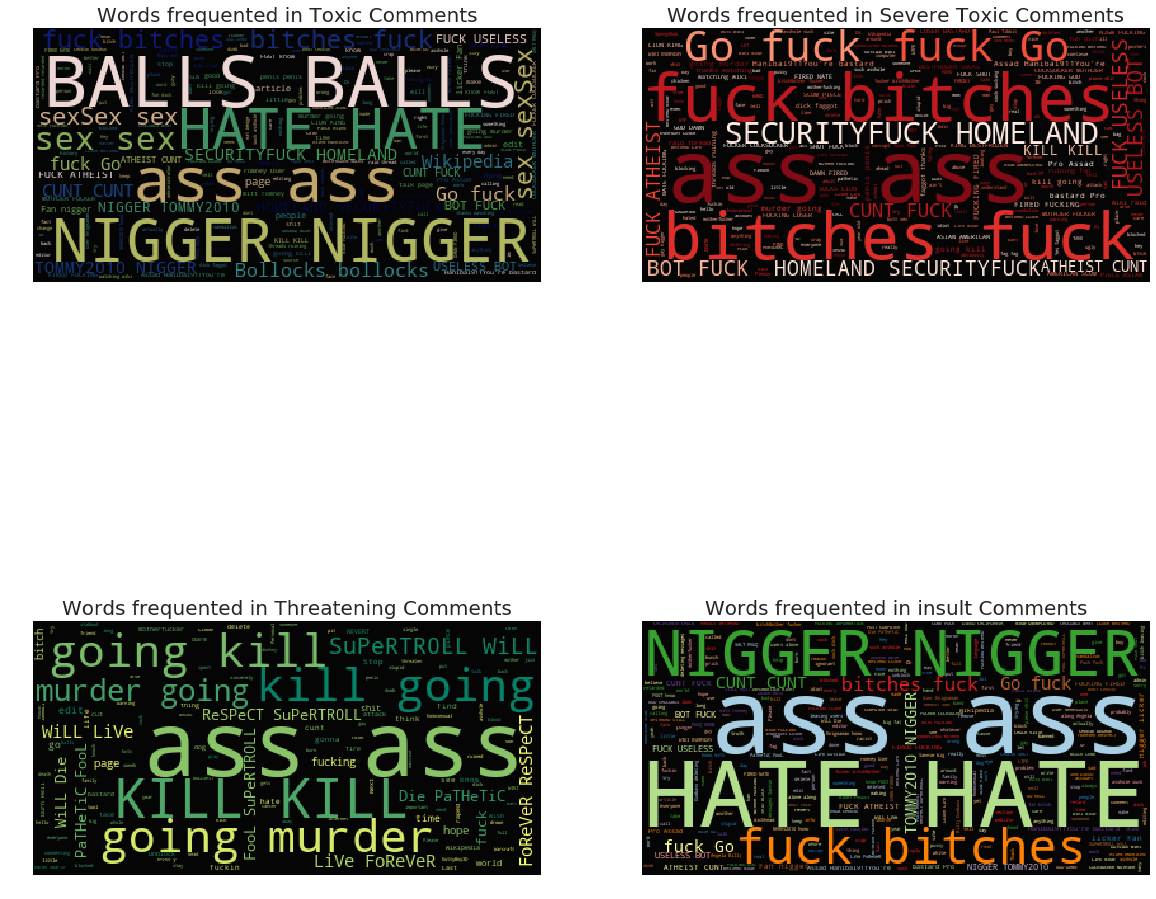

In [18]:
stopword=set(STOPWORDS)

#wordcloud for clean comments
subset=train[train.clean==True]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(20,10))
plt.axis("off")
plt.title("Words frequented in Clean Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.show()

#wordcloud for toxic comments
subset=train[train.toxic==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=4000,stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.axis("off")
plt.title("Words frequented in Toxic Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'gist_earth' , random_state=244), alpha=0.98)

#Severely toxic comments
plt.subplot(222)
subset=train[train.severe_toxic==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,stopwords=stopword)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Words frequented in Severe Toxic Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Reds' , random_state=244), alpha=0.98)

#Threat comments
plt.subplot(223)
subset=train[train.threat==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,stopwords=stopword)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Words frequented in Threatening Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'summer' , random_state=2534), alpha=0.98)

#insult
plt.subplot(224)
subset=train[train.insult==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,stopwords=stopword)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Words frequented in insult Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Paired_r' , random_state=244), alpha=0.98)

plt.show()

In [19]:
## 2.6 Eksplorowanie właściwości komentarzy


W tym rozdziale przeanalizowane zostana...

In [20]:
merge=pd.concat([train.iloc[:,0:2],test.iloc[:,0:2]])
df=merge.reset_index(drop=True)

Polaczenie zbiorow trenującego oraz testowego w celu zliczenia znaków, słów i zdań

In [21]:
#Sentense count in each comment:
    #  '\n' can be used to count the number of sentences in each comment
df['count_sent']=df["comment_text"].apply(lambda x: len(re.findall("\n",str(x)))+1)
#Word count in each comment:
df['count_word']=df["comment_text"].apply(lambda x: len(str(x).split()))
#Unique word count
df['count_unique_word']=df["comment_text"].apply(lambda x: len(set(str(x).split())))
#Letter count
df['count_letters']=df["comment_text"].apply(lambda x: len(str(x)))
#punctuation count
df["count_punctuations"] =df["comment_text"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
#upper case words count
df["count_words_upper"] = df["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
#title case words count
df["count_words_title"] = df["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
#Number of stopwords
df["count_stopwords"] = df["comment_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
#Average length of the words
df["mean_word_len"] = df["comment_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

Zliczenie takich właściwości komentarzy jak:
    1. liczba słów

In [22]:
#derived features
#Word count percent in each comment:
df['word_unique_percent']=df['count_unique_word']*100/df['count_word']
#derived features
#Punct percent in each comment:
df['punct_percent']=df['count_punctuations']*100/df['count_word']

Powyzszy kod zlicza zawartość procentowa

In [23]:
#serperate train and test features
train_feats=df.iloc[0:len(train),]
test_feats=df.iloc[len(train):,]
#join the tags
train_tags=train.iloc[:,2:]
train_feats=pd.concat([train_feats,train_tags],axis=1)

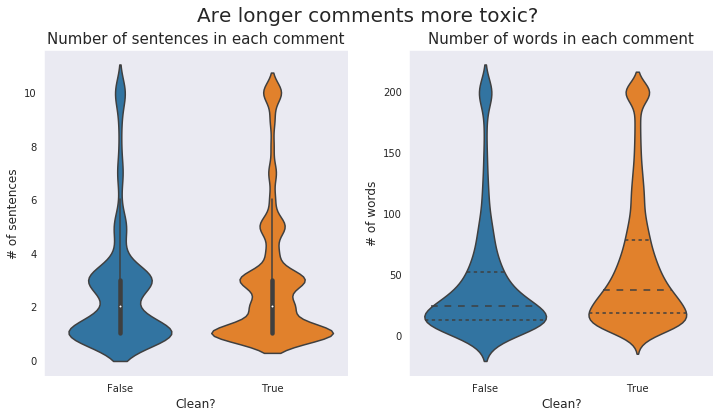

In [24]:
train_feats['count_sent'].loc[train_feats['count_sent']>10] = 10 
plt.figure(figsize=(12,6))
## sentenses
plt.subplot(121)
plt.suptitle("Are longer comments more toxic?",fontsize=20)
sns.violinplot(y='count_sent',x='clean', data=train_feats,split=True)
plt.xlabel('Clean?', fontsize=12)
plt.ylabel('# of sentences', fontsize=12)
plt.title("Number of sentences in each comment", fontsize=15)
# words
train_feats['count_word'].loc[train_feats['count_word']>200] = 200
plt.subplot(122)
sns.violinplot(y='count_word',x='clean', data=train_feats,split=True,inner="quart")
plt.xlabel('Clean?', fontsize=12)
plt.ylabel('# of words', fontsize=12)
plt.title("Number of words in each comment", fontsize=15)

plt.show()

Wnioski z wykresów. Long sentences or more words do not seem to be a significant indicator of toxicity.

Chart desc: Violin plot is an alternative to the traditional box plot. The inner markings show the percentiles while the width of the "violin" shows the volume of comments at that level/instance.

In [25]:
train_feats['count_unique_word'].loc[train_feats['count_unique_word']>200] = 200
#prep for split violin plots
#For the desired plots , the data must be in long format
temp_df = pd.melt(train_feats, value_vars=['count_word', 'count_unique_word'], id_vars='clean')
#spammers - comments with less than 40% unique words
spammers=train_feats[train_feats['word_unique_percent']<30]

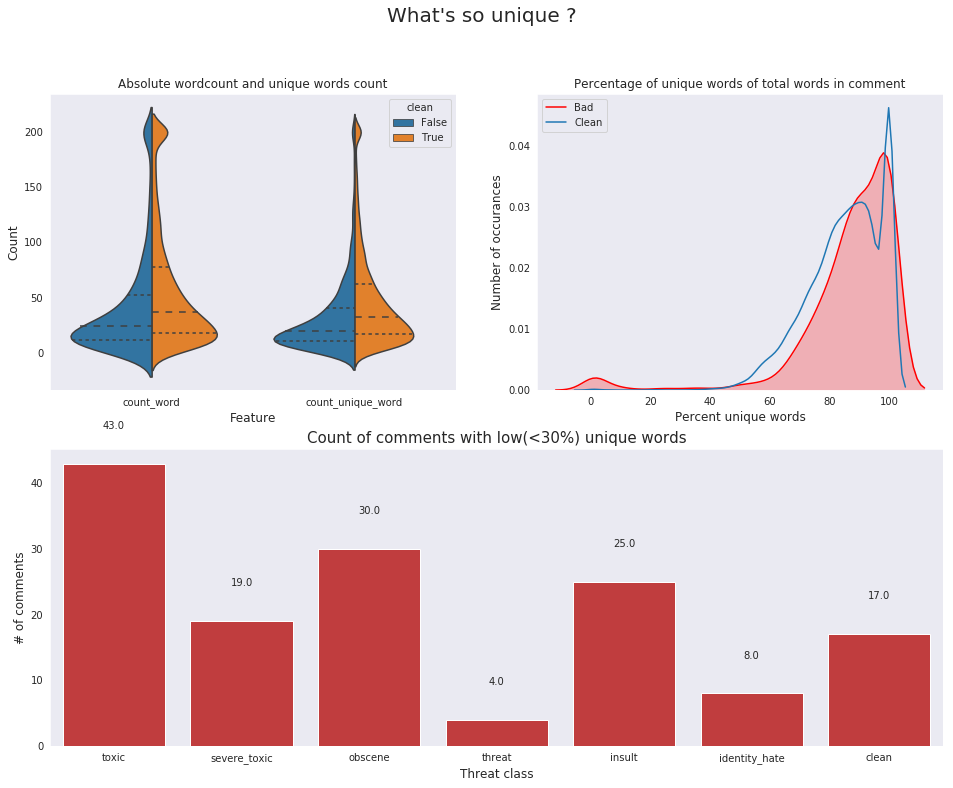

In [26]:
plt.figure(figsize=(16,12))
plt.suptitle("What's so unique ?",fontsize=20)
gridspec.GridSpec(2,2)
plt.subplot2grid((2,2),(0,0))
sns.violinplot(x='variable', y='value', hue='clean', data=temp_df, split=True, inner='quartile')
plt.title("Absolute wordcount and unique words count")
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.subplot2grid((2,2),(0,1))
plt.title("Percentage of unique words of total words in comment")
#sns.boxplot(x='clean', y='word_unique_percent', data=train_feats)
ax=sns.kdeplot(train_feats[train_feats.clean == 0].word_unique_percent, label="Bad",shade=True,color='r')
ax=sns.kdeplot(train_feats[train_feats.clean == 1].word_unique_percent, label="Clean")
plt.legend()
plt.ylabel('Number of occurances', fontsize=12)
plt.xlabel('Percent unique words', fontsize=12)

x=spammers.iloc[:,-7:].sum()
plt.subplot2grid((2,2),(1,0),colspan=2)
plt.title("Count of comments with low(<30%) unique words",fontsize=15)
ax=sns.barplot(x=x.index, y=x.values,color=color[3])

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.xlabel('Threat class', fontsize=12)
plt.ylabel('# of comments', fontsize=12)
plt.show()

Word count VS unique word count:
There are noticeable shifts in the mean of both word count and unique word count across clean and toxic comments.

Chart desc: The first chart is a split violin chart. It is a variation of the traditional box chart/violin chart which allows us to split the violin in the middle based on a categorical variable.
Unique word count percent:
There is a bulge near the 0-10% mark which indicates a large number of toxic comments which contain very little variety of words.

Chart desc: The second chart is an overlay of two kernel density estimation plots of percentage of unique words out of all the words in the comment, done for both clean and toxic comments
Even though the number of clean comments dominates the dataset(~90%), there are only 75 clean comments that are spam, which makes it a powerful indicator of a toxic comment.



# Corpus cleaning:
Its important to use a clean dataset before creating count features.

In [27]:
corpus=merge.comment_text

Łączymy korpusy...

In [28]:
#https://drive.google.com/file/d/0B1yuv8YaUVlZZ1RzMFJmc1ZsQmM/view
# Aphost lookup dict
APPO = {
"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not",
"tryin'":"trying"
}

Mapowanie wyrażeń apostrofowych...

In [29]:
def clean(comment):
    """
    This function receives comments and returns clean word-list
    """
    #Convert to lower case , so that Hi and hi are the same
    comment=comment.lower()
    #remove \n
    comment=re.sub("\\n","",comment)
    # remove leaky elements like ip,user
    comment=re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}","",comment)
    #removing usernames
    comment=re.sub("\[\[.*\]","",comment)
    #removing links
    comment=re.sub("https?://.*com","",comment)

    #Split the sentences into words
    words=tokenizer.tokenize(comment)

    # (')aphostophe  replacement (ie)   you're --> you are
    # ( basic dictionary lookup : master dictionary present in a hidden block of code)
    words=[APPO[word] if word in APPO else word for word in words]
    words=[lem.lemmatize(word, "v") for word in words]
    words = [w for w in words if not w in eng_stopwords]

    clean_sent=" ".join(words)
    # remove any non alphanum,digit character
    #clean_sent=re.sub("\W+"," ",clean_sent)
    #clean_sent=re.sub("  "," ",clean_sent)
    return(clean_sent)

DUZO OPISU METOD CZYSZCZENIA

In [30]:
corpus.iloc[1675]


'"\n\nhey fuck you, who the fuck checks ""Phnom Nam Lyr Wildlife Sanctuary"" for vandalism. Get a fucking life you turd bag"'

Komentarz zwykly...

In [31]:
clean(corpus.iloc[1675])


'" hey fuck , fuck check " " phnom nam lyr wildlife sanctuary " " vandalism . get fuck life turd bag "'

Komentarz po oczyszczeniu

In [32]:
clean_corpus=corpus.apply(lambda x :clean(x))

Calkowite wyczyszczenie korpusu komentarzy

# 3. Wektoryzacja korpusu

Direct features:
1)Count based features(for unigrams):
Lets create some features based on frequency distribution of the words. Initially lets consider taking words one at a time (ie) Unigrams

Python's SKlearn provides 3 ways of creating count features.All three of them first create a vocabulary(dictionary) of words and then create a sparse matrix of word counts for the words in the sentence that are present in the dictionary. A brief description of them:

CountVectorizer
Creates a matrix with frequency counts of each word in the text corpus
TF-IDF Vectorizer
TF - Term Frequency -- Count of the words(Terms) in the text corpus (same of Count Vect)
IDF - Inverse Document Frequency -- Penalizes words that are too frequent. We can think of this as regularization
HashingVectorizer
Creates a hashmap(word to number mapping based on hashing technique) instead of a dictionary for vocabulary
This enables it to be more scalable and faster for larger text coprus
Can be parallelized across multiple threads
Using TF-IDF here. Note: Using the concatenated dataframe "merge" which contains both text from train and test dataset to ensure that the vocabulary that we create does not missout on the words that are unique to testset.

## 3.1 Unigramowa reprezentacja tekstu

In [33]:
### Unigrams -- TF-IDF 
# using settings recommended here for TF-IDF -- https://www.kaggle.com/abhishek/approaching-almost-any-nlp-problem-on-kaggle

#some detailed description of the parameters
# min_df=10 --- ignore terms that appear lesser than 10 times 
# max_features=None  --- Create as many words as present in the text corpus
    # changing max_features to 10k for memmory issues
# analyzer='word'  --- Create features from words (alternatively char can also be used)
# ngram_range=(1,1)  --- Use only one word at a time (unigrams)
# strip_accents='unicode' -- removes accents
# use_idf=1,smooth_idf=1 --- enable IDF
# sublinear_tf=1   --- Apply sublinear tf scaling, i.e. replace tf with 1 + log(tf)


#temp settings to min=200 to facilitate top features section to run in kernals
#change back to min=10 to get better results
start_unigrams=time.time()
tfv = TfidfVectorizer(min_df=200,  max_features=10000, 
            strip_accents='unicode', analyzer='word',ngram_range=(1,1),
            use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')
tfv.fit(clean_corpus)
features = np.array(tfv.get_feature_names())

train_unigrams =  tfv.transform(clean_corpus.iloc[:train.shape[0]])
test_unigrams = tfv.transform(clean_corpus.iloc[train.shape[0]:])

Powyzsze funkcje...

In [34]:
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    ''' Top tfidf features in specific document (matrix row) '''
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

def top_mean_feats(Xtr, features, grp_ids, min_tfidf=0.1, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''

    D = Xtr[grp_ids].toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

# modified for multilabel milticlass
def top_feats_by_class(Xtr, features, min_tfidf=0.1, top_n=20):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. '''
    dfs = []
    cols=train_tags.columns
    for col in cols:
        ids = train_tags.index[train_tags[col]==1]
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

https://buhrmann.github.io/tfidf-analysis.html
w repozytorium...


In [35]:
#get top n for unigrams
tfidf_top_n_per_lass=top_feats_by_class(train_unigrams,features)

topka najpopularniejszych słów

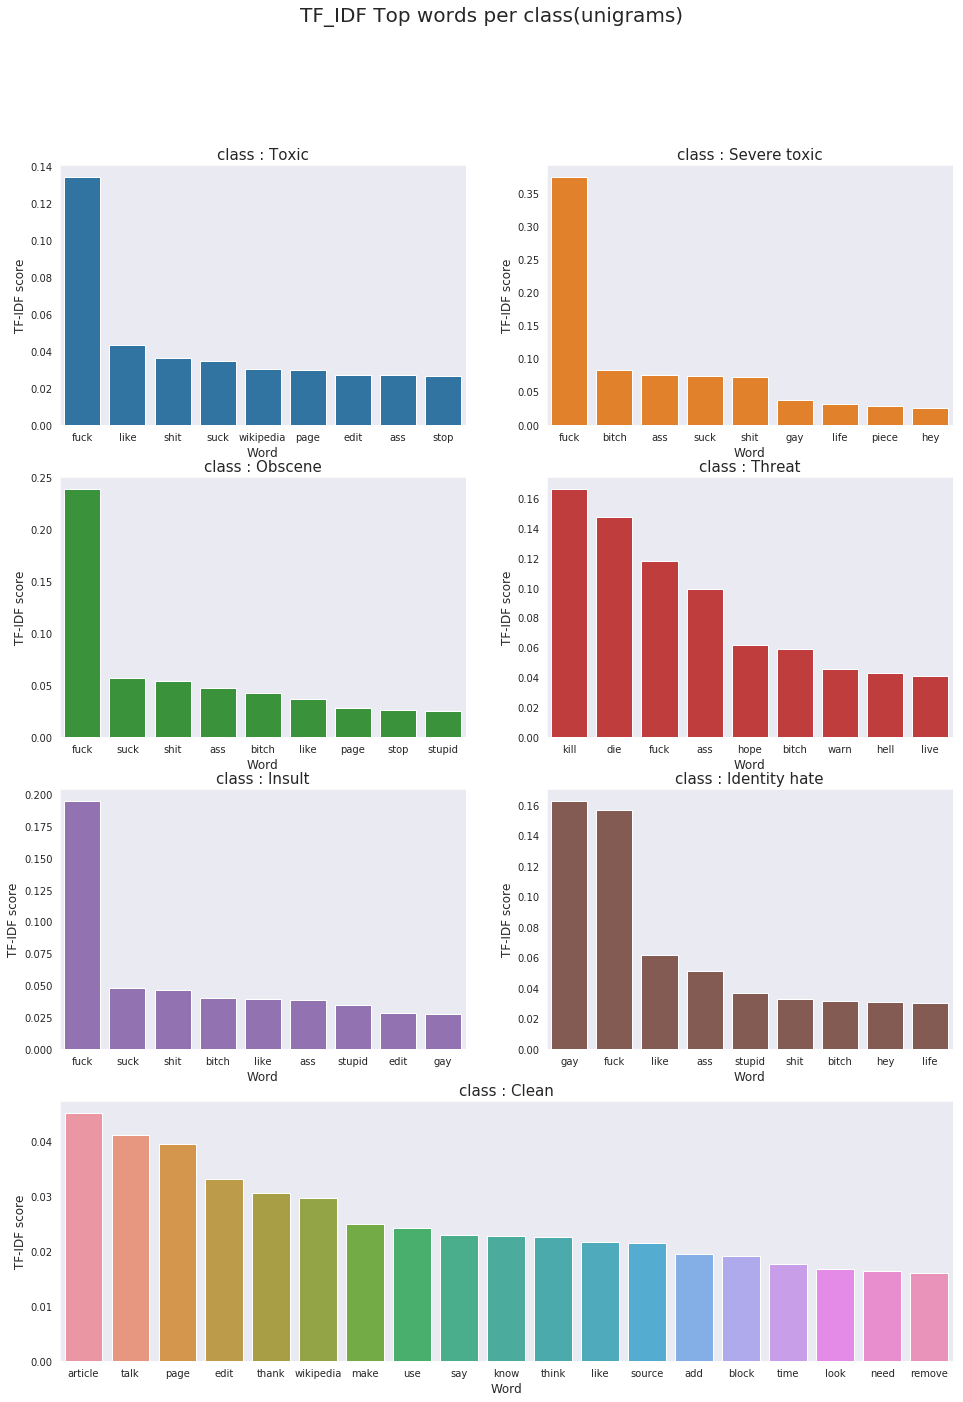

In [36]:
plt.figure(figsize=(16,22))
plt.suptitle("TF_IDF Top words per class(unigrams)",fontsize=20)
gridspec.GridSpec(4,2)
plt.subplot2grid((4,2),(0,0))
sns.barplot(tfidf_top_n_per_lass[0].feature.iloc[0:9],tfidf_top_n_per_lass[0].tfidf.iloc[0:9],color=color[0])
plt.title("class : Toxic",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

plt.subplot2grid((4,2),(0,1))
sns.barplot(tfidf_top_n_per_lass[1].feature.iloc[0:9],tfidf_top_n_per_lass[1].tfidf.iloc[0:9],color=color[1])
plt.title("class : Severe toxic",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(1,0))
sns.barplot(tfidf_top_n_per_lass[2].feature.iloc[0:9],tfidf_top_n_per_lass[2].tfidf.iloc[0:9],color=color[2])
plt.title("class : Obscene",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(1,1))
sns.barplot(tfidf_top_n_per_lass[3].feature.iloc[0:9],tfidf_top_n_per_lass[3].tfidf.iloc[0:9],color=color[3])
plt.title("class : Threat",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(2,0))
sns.barplot(tfidf_top_n_per_lass[4].feature.iloc[0:9],tfidf_top_n_per_lass[4].tfidf.iloc[0:9],color=color[4])
plt.title("class : Insult",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(2,1))
sns.barplot(tfidf_top_n_per_lass[5].feature.iloc[0:9],tfidf_top_n_per_lass[5].tfidf.iloc[0:9],color=color[5])
plt.title("class : Identity hate",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(3,0),colspan=2)
sns.barplot(tfidf_top_n_per_lass[6].feature.iloc[0:19],tfidf_top_n_per_lass[6].tfidf.iloc[0:19])
plt.title("class : Clean",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

plt.show()

## 3.2 Bigramowa reprezentacja tekstu

In [37]:
#temp settings to min=150 to facilitate top features section to run in kernals
#change back to min=10 to get better results
tfv = TfidfVectorizer(min_df=150,  max_features=30000, 
            strip_accents='unicode', analyzer='word',ngram_range=(2,2),
            use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

tfv.fit(clean_corpus)
features = np.array(tfv.get_feature_names())
train_bigrams =  tfv.transform(clean_corpus.iloc[:train.shape[0]])
test_bigrams = tfv.transform(clean_corpus.iloc[train.shape[0]:])
#get top n for bigrams
tfidf_top_n_per_lass=top_feats_by_class(train_bigrams,features)

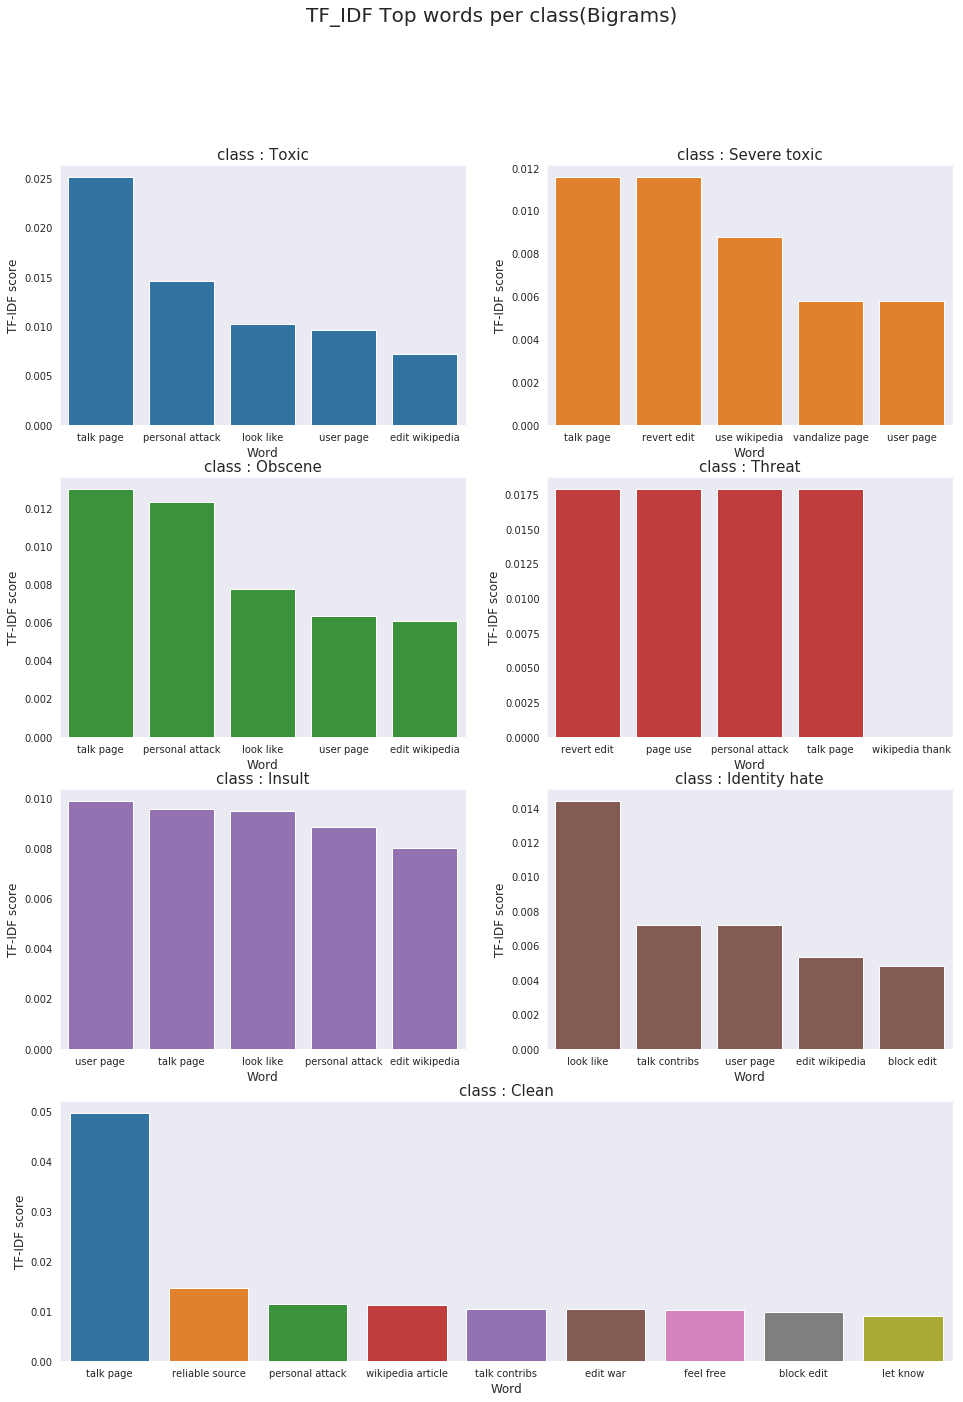

In [38]:
plt.figure(figsize=(16,22))
plt.suptitle("TF_IDF Top words per class(Bigrams)",fontsize=20)
gridspec.GridSpec(4,2)
plt.subplot2grid((4,2),(0,0))
sns.barplot(tfidf_top_n_per_lass[0].feature.iloc[0:5],tfidf_top_n_per_lass[0].tfidf.iloc[0:5],color=color[0])
plt.title("class : Toxic",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

plt.subplot2grid((4,2),(0,1))
sns.barplot(tfidf_top_n_per_lass[1].feature.iloc[0:5],tfidf_top_n_per_lass[1].tfidf.iloc[0:5],color=color[1])
plt.title("class : Severe toxic",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(1,0))
sns.barplot(tfidf_top_n_per_lass[2].feature.iloc[0:5],tfidf_top_n_per_lass[2].tfidf.iloc[0:5],color=color[2])
plt.title("class : Obscene",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(1,1))
sns.barplot(tfidf_top_n_per_lass[3].feature.iloc[0:5],tfidf_top_n_per_lass[3].tfidf.iloc[0:5],color=color[3])
plt.title("class : Threat",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(2,0))
sns.barplot(tfidf_top_n_per_lass[4].feature.iloc[0:5],tfidf_top_n_per_lass[4].tfidf.iloc[0:5],color=color[4])
plt.title("class : Insult",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(2,1))
sns.barplot(tfidf_top_n_per_lass[5].feature.iloc[0:5],tfidf_top_n_per_lass[5].tfidf.iloc[0:5],color=color[5])
plt.title("class : Identity hate",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(3,0),colspan=2)
sns.barplot(tfidf_top_n_per_lass[6].feature.iloc[0:9],tfidf_top_n_per_lass[6].tfidf.iloc[0:9])
plt.title("class : Clean",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

plt.show()

# 4. Budowa modelu klasyfikatora

blablabla

## 4.1 Model NB-SVM 

fff

In [39]:
class NbSvmClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, C=1.0, dual=False, n_jobs=1):
        self.C = C
        self.dual = dual
        self.n_jobs = n_jobs

    def predict(self, x):
        # Verify that model has been fit
        check_is_fitted(self, ['_r', '_clf'])
        return self._clf.predict(x.multiply(self._r))

    def predict_proba(self, x):
        # Verify that model has been fit
        check_is_fitted(self, ['_r', '_clf'])
        return self._clf.predict_proba(x.multiply(self._r))

    def fit(self, x, y):
        # Check that X and y have correct shape
        y = y.values
        x, y = check_X_y(x, y, accept_sparse=True)

        def pr(x, y_i, y):
            p = x[y==y_i].sum(0)
            return (p+1) / ((y==y_i).sum()+1)

        self._r = sparse.csr_matrix(np.log(pr(x,1,y) / pr(x,0,y)))
        x_nb = x.multiply(self._r)
        self._clf = LogisticRegression(C=self.C, dual=self.dual, n_jobs=self.n_jobs).fit(x_nb, y)
        return self
    
# model = NbSvmClassifier(C=4, dual=True, n_jobs=-1)

blablabla

In [40]:
SELECTED_COLS=['count_sent', 'count_word', 'count_unique_word',
       'count_letters', 'count_punctuations', 'count_words_upper',
       'count_words_title', 'count_stopwords', 'mean_word_len',
       'word_unique_percent', 'punct_percent']
target_x=train_feats[SELECTED_COLS]
# target_x

TARGET_COLS=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
target_y=train_tags[TARGET_COLS]

# Strat k fold due to imbalanced classes
# split = StratifiedKFold(n_splits=2, random_state=1)

#https://www.kaggle.com/yekenot/toxic-regression

blablabla

In [41]:
#Just the indirect features -- meta features
print("Using only Indirect features")
model = LogisticRegression(C=3)
X_train, X_valid, y_train, y_valid = train_test_split(target_x, target_y, test_size=0.33, random_state=2018)
train_loss = []
valid_loss = []
importance=[]
preds_train = np.zeros((X_train.shape[0], len(y_train)))
preds_valid = np.zeros((X_valid.shape[0], len(y_valid)))
for i, j in enumerate(TARGET_COLS):
    print('Class:= '+j)
    model.fit(X_train,y_train[j])
    preds_valid[:,i] = model.predict_proba(X_valid)[:,1]
    preds_train[:,i] = model.predict_proba(X_train)[:,1]
    train_loss_class=log_loss(y_train[j],preds_train[:,i])
    valid_loss_class=log_loss(y_valid[j],preds_valid[:,i])
    print('Trainloss=log loss:', train_loss_class)
    print('Validloss=log loss:', valid_loss_class)
    importance.append(model.coef_)
    train_loss.append(train_loss_class)
    valid_loss.append(valid_loss_class)
print('mean column-wise log loss:Train dataset', np.mean(train_loss))
print('mean column-wise log loss:Validation dataset', np.mean(valid_loss))

Using only Indirect features
Class:= toxic
Trainloss=log loss: 0.29937257061116507
Validloss=log loss: 0.292165397599532
Class:= severe_toxic
Trainloss=log loss: 0.05377866169438294
Validloss=log loss: 0.06038099966250253
Class:= obscene
Trainloss=log loss: 0.19144254404689373
Validloss=log loss: 0.21485202735337625
Class:= threat
Trainloss=log loss: 0.016889181375856953
Validloss=log loss: 0.03696181019479836
Class:= insult
Trainloss=log loss: 0.18390458287807546
Validloss=log loss: 0.19984642804115443
Class:= identity_hate
Trainloss=log loss: 0.04469543226924502
Validloss=log loss: 0.05235366951738504
mean column-wise log loss:Train dataset 0.13168049547926985
mean column-wise log loss:Validation dataset 0.14276005539479145


blabla

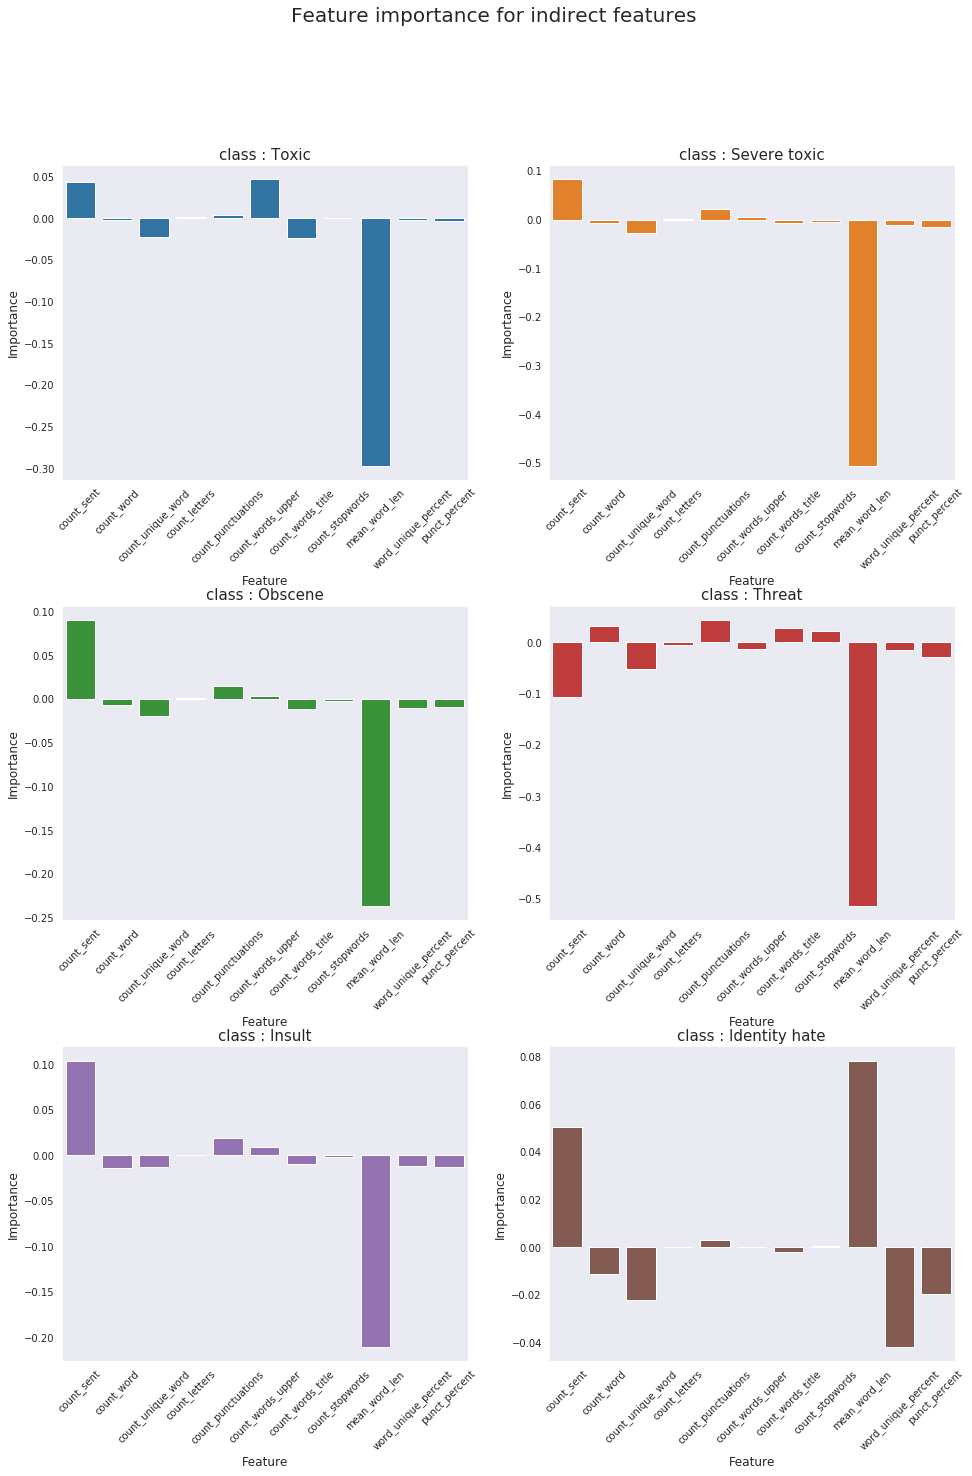

In [42]:
plt.figure(figsize=(16,22))
plt.suptitle("Feature importance for indirect features",fontsize=20)
gridspec.GridSpec(3,2)
plt.subplots_adjust(hspace=0.4)
plt.subplot2grid((3,2),(0,0))
sns.barplot(SELECTED_COLS,importance[0][0],color=color[0])
plt.title("class : Toxic",fontsize=15)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Importance', fontsize=12)

plt.subplot2grid((3,2),(0,1))
sns.barplot(SELECTED_COLS,importance[1][0],color=color[1])
plt.title("class : Severe toxic",fontsize=15)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Importance', fontsize=12)

plt.subplot2grid((3,2),(1,0))
sns.barplot(SELECTED_COLS,importance[2][0],color=color[2])
plt.title("class : Obscene",fontsize=15)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Importance', fontsize=12)



plt.subplot2grid((3,2),(1,1))
sns.barplot(SELECTED_COLS,importance[3][0],color=color[3])
plt.title("class : Threat",fontsize=15)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Importance', fontsize=12)


plt.subplot2grid((3,2),(2,0))
sns.barplot(SELECTED_COLS,importance[4][0],color=color[4])
plt.title("class : Insult",fontsize=15)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Importance', fontsize=12)


plt.subplot2grid((3,2),(2,1))
sns.barplot(SELECTED_COLS,importance[5][0],color=color[5])
plt.title("class : Identity hate",fontsize=15)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Importance', fontsize=12)


# plt.subplot2grid((4,2),(3,0),colspan=2)
# sns.barplot(SELECTED_COLS,importance[6][0],color=color[0])
# plt.title("class : Clean",fontsize=15)
# locs, labels = plt.xticks()
# plt.setp(labels, rotation=90)
# plt.xlabel('Feature', fontsize=12)
# plt.ylabel('Importance', fontsize=12)

plt.show()

blabla

In [44]:
from scipy.sparse import csr_matrix, hstack

#Using all direct features
print("Using all features except leaky ones")
target_x = hstack((train_bigrams,train_unigrams,train_feats[SELECTED_COLS])).tocsr()

Using all features except leaky ones


In [45]:
model = NbSvmClassifier(C=4, dual=True, n_jobs=-1)
X_train, X_valid, y_train, y_valid = train_test_split(target_x, target_y, test_size=0.33, random_state=2018)
train_loss = []
valid_loss = []
preds_train = np.zeros((X_train.shape[0], len(y_train)))
preds_valid = np.zeros((X_valid.shape[0], len(y_valid)))
for i, j in enumerate(TARGET_COLS):
    print('Class:= '+j)
    model.fit(X_train,y_train[j])
    preds_valid[:,i] = model.predict_proba(X_valid)[:,1]
    preds_train[:,i] = model.predict_proba(X_train)[:,1]
    train_loss_class=log_loss(y_train[j],preds_train[:,i])
    valid_loss_class=log_loss(y_valid[j],preds_valid[:,i])
    print('Trainloss=log loss:', train_loss_class)
    print('Validloss=log loss:', valid_loss_class)
    train_loss.append(train_loss_class)
    valid_loss.append(valid_loss_class)
print('mean column-wise log loss:Train dataset', np.mean(train_loss))
print('mean column-wise log loss:Validation dataset', np.mean(valid_loss))

Class:= toxic
Trainloss=log loss: 0.2039653229615847
Validloss=log loss: 0.2043771800922849
Class:= severe_toxic
Trainloss=log loss: 0.07477187305766014
Validloss=log loss: 0.059839958025123326
Class:= obscene
Trainloss=log loss: 0.12611025849015936
Validloss=log loss: 0.16667876669814624
Class:= threat
Trainloss=log loss: 0.020088234206092147
Validloss=log loss: 0.039988144230441905
Class:= insult
Trainloss=log loss: 0.16441561754257805
Validloss=log loss: 0.18252668756108986
Class:= identity_hate
Trainloss=log loss: 0.04464513086153421
Validloss=log loss: 0.05321770390481498
mean column-wise log loss:Train dataset 0.10566607285326811
mean column-wise log loss:Validation dataset 0.11777140675198354


blabla


## 4.1 Sieć neuronowa

This notebook attempts to tackle this classification problem by using Keras LSTM. 
While there are many notebook out there that are already tackling using this approach, I feel that there isn't enough explanation to what is going on each step. As someone who has been using vanilla Tensorflow, and recently embraced the wonderful world of Keras, I hope to share with fellow beginners the intuition that I gained from my research and study.

Join me as we walk through it.

In [46]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(clean_corpus.iloc[:train.shape[0]]))
list_tokenized_train = tokenizer.texts_to_sequences(clean_corpus.iloc[:train.shape[0]])
list_tokenized_test = tokenizer.texts_to_sequences(clean_corpus.iloc[train.shape[0]:])

Now, if you look at "list_tokenized_train", you will see that Keras has turned our words into index representation for us

In [47]:
list_tokenized_train[:1]


[[5,
  12,
  517,
  3541,
  14068,
  327,
  74,
  1821,
  3,
  7199,
  5198,
  2755,
  491,
  69,
  1093,
  8056,
  2414,
  15,
  21,
  3,
  43,
  295,
  6,
  2,
  90,
  7,
  30,
  2415]]

But there's still 1 problem! What if some comments are terribly long, while some are just 1 word? Wouldn't our indexed-sentence look like this:

Comment #1: [8,9,3,7,3,6,3,6,3,6,2,3,4,9]

Comment #2: [1,2]

And we have to feed a stream of data that has a consistent length(fixed number of features) isn't it?

And this is why we use "padding"! We could make the shorter sentences as long as the others by filling the shortfall by zeros.But on the other hand, we also have to trim the longer ones to the same length(maxlen) as the short ones. In this case, we have set the max length to be 200.

In [61]:
maxlen = 200
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)
y = train[class_names].values

How do you know what is the best "maxlen" to set? If you put it too short, you might lose some useful feature that could cost you some accuracy points down the path.If you put it too long, your LSTM cell will have to be larger to store the possible values or states.

One of the ways to go about it is to see the distribution of the number of words in sentences.

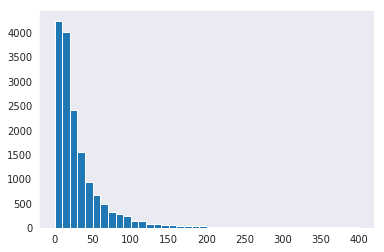

In [49]:
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]

plt.hist(totalNumWords,bins = np.arange(0,410,10))#[0,50,100,150,200,250,300,350,400])#,450,500,550,600,650,700,750,800,850,900])
plt.show()

As we can see, most of the sentence length is about 30+. We could set the "maxlen" to about 50, but I'm being paranoid so I have set to 200. Then again, it sounds like something you could experiment and see what is the magic number.

Finally the start of building our model!

This is the architecture of the model we are trying to build. It's always to good idea to list out the dimensions of each layer in the model to think visually and help you to debug later on.

As mentioned earlier, the inputs into our networks are our list of encoded sentences

We begin our defining an Input layer that accepts a list of sentences that has a dimension of 200. By indicating an empty space after comma, we are telling Keras to infer the number automatically.

In [50]:
inp = Input(shape=(maxlen, )) #maxlen=200 as defined earlier

Next, we pass it to our Embedding layer, where we project the words to a defined vector space depending on the distance of the surrounding words in a sentence. Embedding allows us to reduce model size and most importantly the huge dimensions we have to deal with, in the case of using one-hot encoding to represent the words in our sentence. The output of the Embedding layer is just a list of the coordinates of the words in this vector space. For eg. (-81.012) for "cat" and (-80.012) for "dog". We could also use the distance of these coordinates to detect relevance and context. Embedding is a pretty deep topic, and if you are interested, this is a comprehensive guide: https://www.analyticsvidhya.com/blog/2017/06/word-embeddings-count-word2veec/

We need to define the size of the "vector space" we have mentioned above, and the number of unique words(max_features) we are using. Again, the embedding size is a parameter that you can tune and experiment.



In [51]:
embed_size = 128
x = Embedding(max_features, embed_size)(inp)

The embedding layer outputs a 3-D tensor of (None, 200, 128). Which is an array of sentence(None means that it's size is inferred), and for each words(200), there is an array of 128 coordinates in the vector space of embedding.

Next, we feed this Tensor into the LSTM layer. We set the LSTM to produce an output that has a dimension of 60 and want it to return the whole unrolled sequence of results. As you probably know, LSTM or RNN works by recursively feeding the output of a previous network into the input of the current network, and you would take the final output after X number of recursion. But depending on use cases, you might want to take the unrolled, or the outputs of each recursion as the result to pass to the next layer. And this is the case.

From the short line of code that defines the LSTM layer, it's easy to miss the required input dimensions. LSTM takes in a tensor of [Batch Size, Time Steps, Number of Inputs]. Batch size is the number of samples in a batch, time steps is the number of recursion it runs for each input, or it could be pictured as the number of "A"s in the above picture. Lastly, number of inputs is the number of variables(number of words in each sentence in our case) you pass into LSTM as pictured in "x" above.

We can make use of the output from the previous embedding layer which outputs a 3-D tensor of (None, 200, 128) into the LSTM layer. What it does is going through the samples, recursively run the LSTM model for 200 times, passing in the coordinates of the words each time. And because we want the unrolled version, we will receive a Tensor shape of (None, 200, 60), where 60 is the output dimension we have defined.

In [52]:
x = LSTM(60, return_sequences=True,name='lstm_layer')(x)

Before we could pass the output to a normal layer, we need to reshape the 3D tensor into a 2D one. We reshape carefully to avoid throwing away data that is important to us, and ideally we want the resulting data to be a good representative of the original data.

Therefore, we use a Global Max Pooling layer which is traditionally used in CNN problems to reduce the dimensionality of image data. In simple terms, we go through each patch of data, and we take the maximum values of each patch. These collection of maximum values will be a new set of down-sized data we can use.

As you can see from other Kaggle kernels, different variants (Average,Max,etc) of pooling layers are used for dimensionality reduction and they could yield different results so do try them out.

If you are interested in finding out the technical details of pooling, read up here: https://wiseodd.github.io/techblog/2016/07/18/convnet-maxpool-layer/

In [53]:
x = GlobalMaxPool1D()(x)

With a 2D Tensor in our hands, we pass it to a Dropout layer which indiscriminately "disable" some nodes so that the nodes in the next layer is forced to handle the representation of the missing data and the whole network could result in better generalization. 

We set the dropout layer to drop out 10%(0.1) of the nodes.

In [54]:
x = Dropout(0.1)(x)

After a drop out layer, we connect the output of drop out layer to a densely connected layer and the output passes through a RELU function. In short, this is what it does:

Activation( (Input X Weights) + Bias)

all in 1 line, with the weights, bias and activation layer all set up for you! We have defined the Dense layer to produce a output dimension of 50.

In [55]:
x = Dense(50, activation="relu")(x)


We feed the output into a Dropout layer again.



In [56]:
x = Dropout(0.1)(x)


Finally, we feed the output into a Sigmoid layer. The reason why sigmoid is used is because we are trying to achieve a binary classification(1,0) for each of the 6 labels, and the sigmoid function will squash the output between the bounds of 0 and 1.

In [57]:
x = Dense(6, activation="sigmoid")(x)

We are almost done! All is left is to define the inputs, outputs and configure the learning process. We have set our model to optimize our loss function using Adam optimizer, define the loss function to be "binary_crossentropy" since we are tackling a binary classification. In case you are looking for the learning rate, the default is set at 0.001.

In [58]:
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

The moment that we have been waiting for as arrived! It's finally time to put our model to the test. We'll feed in a list of 32 padded, indexed sentence for each batch and split 10% of the data as a validation set. This validation set will be used to assess whether the model has overfitted, for each batch. The model will also run for 2 epochs. These are some of the tunable parameters that you can experiment with, to see if you can push the accurate to the next level without crashing your machine(hence the batch size).

In [69]:
batch_size = 32
epochs = 2
model.fit(X_t, y, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Train on 14611 samples, validate on 1624 samples
Epoch 1/2
14611/14611 [==============================] - 65s 4ms/step - loss: 0.0502 - accuracy: 0.9810 - val_loss: 0.0619 - val_accuracy: 0.9775
Epoch 2/2
14611/14611 [==============================] - 68s 5ms/step - loss: 0.0398 - accuracy: 0.9843 - val_loss: 0.0684 - val_accuracy: 0.9772
